In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("aisdk-2024-02-27.csv", on_bad_lines='skip')

In [3]:
df.shape[0]

15444660

In [4]:
df['# Timestamp'] = pd.to_datetime(df['# Timestamp'])

C:\Users\Sourish\AppData\Local\Temp\ipykernel_12348\1487020443.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['# Timestamp'] = pd.to_datetime(df['# Timestamp'])


In [5]:
null_counts = df.isna().sum()
print(null_counts)

# Timestamp                              0
Type of mobile                           0
MMSI                                     0
Latitude                                 0
Longitude                                0
Navigational status                      0
ROT                                4885362
SOG                                1441965
COG                                2321076
Heading                            3428098
IMO                                      0
Callsign                                 0
Name                               1331545
Ship type                                0
Cargo type                        12818356
Width                              1646591
Length                             1643936
Type of position fixing device           0
Draught                            4042460
Destination                          20478
ETA                                5711299
Data source type                         0
A                                  1679383
B          

In [6]:
df1 = pd.DataFrame(df, columns=["# Timestamp", "MMSI", "Latitude", "Longitude", "SOG", "COG", "Heading"])

In [7]:
df1 = df1.dropna()

In [8]:
null_counts = df1.isna().sum()
print(null_counts)

# Timestamp    0
MMSI           0
Latitude       0
Longitude      0
SOG            0
COG            0
Heading        0
dtype: int64


In [9]:
df1.shape[0]

11631436

In [10]:
df1.head()

,# Timestamp,MMSI,Latitude,Longitude,SOG,COG,Heading
2,2024-02-27,219765000,57.232440,8.663768,9.0,217.0,215.0
5,2024-02-27,209535000,56.771443,10.869177,4.7,297.8,295.0
6,2024-02-27,255806443,55.664585,15.502247,10.9,55.8,57.0
8,2024-02-27,255806443,55.664585,15.502247,10.9,55.8,57.0
11,2024-02-27,209869000,55.358035,13.148208,9.8,16.6,16.0


In [11]:
# Converting Timestamp to a numeric value 
df1['# Timestamp'] = df1['# Timestamp'].astype('datetime64[ns]').astype(np.int64) / 1e9  # Convert to seconds

In [12]:
scaler = StandardScaler()
df_features_normalized = scaler.fit_transform(df1)

In [13]:
# Splitting the data into training and testing sets
x_train, x_test = train_test_split(df_features_normalized, test_size=0.2, random_state=42)

In [14]:
# Building the AutoEncoder model
model = Sequential([
    # Encoder: Reduce dimensionality
    Dense(32, activation='relu', input_shape=(x_train.shape[1],)), # Reducing dimension
    Dense(16, activation='relu'), # Further reducing dimension
    Dense(8, activation='relu'),  # Bottleneck layer

    # Decoder: Reconstruct the features
    Dense(16, activation='relu'), # Start expanding dimension
    Dense(32, activation='relu'), # Continue expanding dimension
    Dense(x_train.shape[1], activation='sigmoid') # Restore to original feature size
])

model.compile(optimizer='adam', loss='mse') 

C:\Users\Sourish\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Training the model
history = model.fit(x_train, x_train, epochs=5, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/5
36349/36349 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 0.5675 - val_loss: 0.5492
Epoch 2/5
36349/36349 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - loss: 0.5495 - val_loss: 0.5491
Epoch 3/5
36349/36349 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 0.5489 - val_loss: 0.5491
Epoch 4/5
36349/36349 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 0.5489 - val_loss: 0.5489
Epoch 5/5
36349/36349 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 0.5493 - val_loss: 0.5489


In [16]:
# Function to calculate reconstruction loss
def calculate_reconstruction_loss(data, model):
    reconstructions = model.predict(data)
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [17]:
# Evaluate the model on test data
reconstruction_loss_normal = calculate_reconstruction_loss(x_test, model)

72697/72697 ━━━━━━━━━━━━━━━━━━━━ 98s 1ms/step


In [18]:
# Create a synthetic anomalous data point
anomalous_data_point = np.random.rand(1, df1.shape[1])
anomalous_data_point_normalized = scaler.transform(anomalous_data_point)
reconstruction_loss_anomalous = calculate_reconstruction_loss(anomalous_data_point_normalized, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\Sourish\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
# Print average reconstruction loss
print(f"Average Reconstruction Loss for Normal Data: {np.mean(reconstruction_loss_normal)}")
print(f"Reconstruction Loss for Anomalous Data: {reconstruction_loss_anomalous[0]}")


Average Reconstruction Loss for Normal Data: 0.5039469923604323
Reconstruction Loss for Anomalous Data: 10003.548221939927


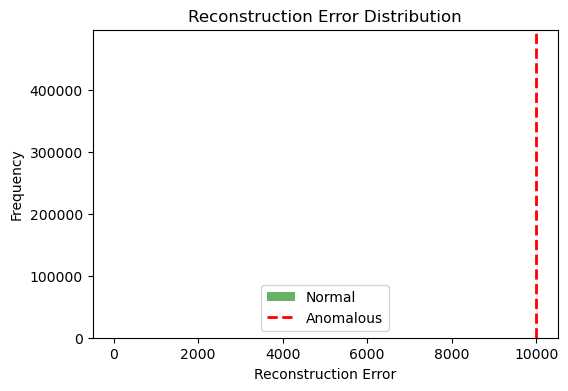

In [20]:
# Visualization of reconstruction error distribution
plt.figure(figsize=(6, 4))
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, color='g', label='Normal')
plt.axvline(x=reconstruction_loss_anomalous[0], color='r', linestyle='dashed', linewidth=2, label='Anomalous')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Number of potential anomalies (above 95th percentile): 116315


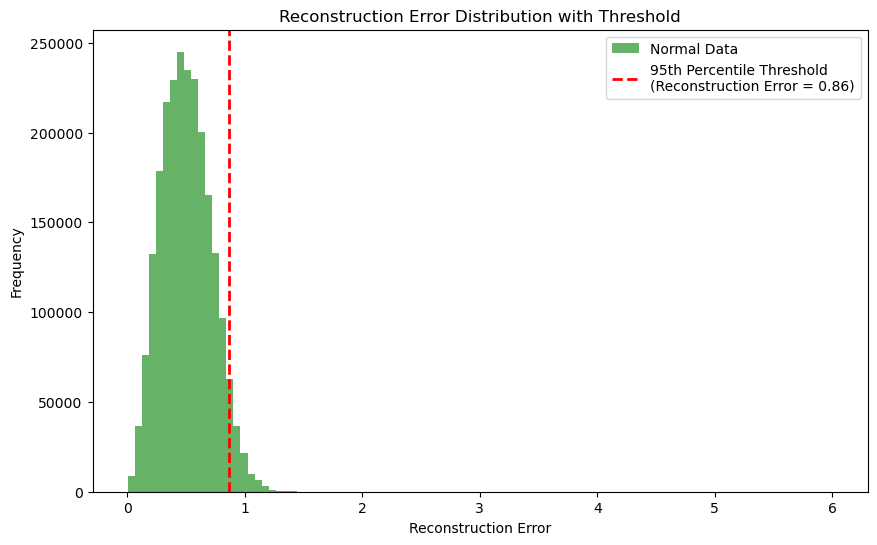

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the reconstruction errors stored in reconstruction_loss_normal

# Step 1: Calculate the 95th percentile threshold
threshold = np.percentile(reconstruction_loss_normal, 95)

# Step 2: Identify anomalies
anomalies = reconstruction_loss_normal > threshold

# Step 3: Count the number of anomalies
num_anomalies = np.sum(anomalies)
print(f"Number of potential anomalies (above 95th percentile): {num_anomalies}")

# Step 4: Visualize the distribution with the threshold
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss_normal, bins=100, alpha=0.6, color='g', label='Normal Data')
plt.axvline(x=threshold, color='r', linestyle='dashed', linewidth=2, label=f'95th Percentile Threshold\n(Reconstruction Error = {threshold:.2f})')
plt.title('Reconstruction Error Distribution with Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Number of potential anomalies: 116315
Percentage of total data points: 5.00%


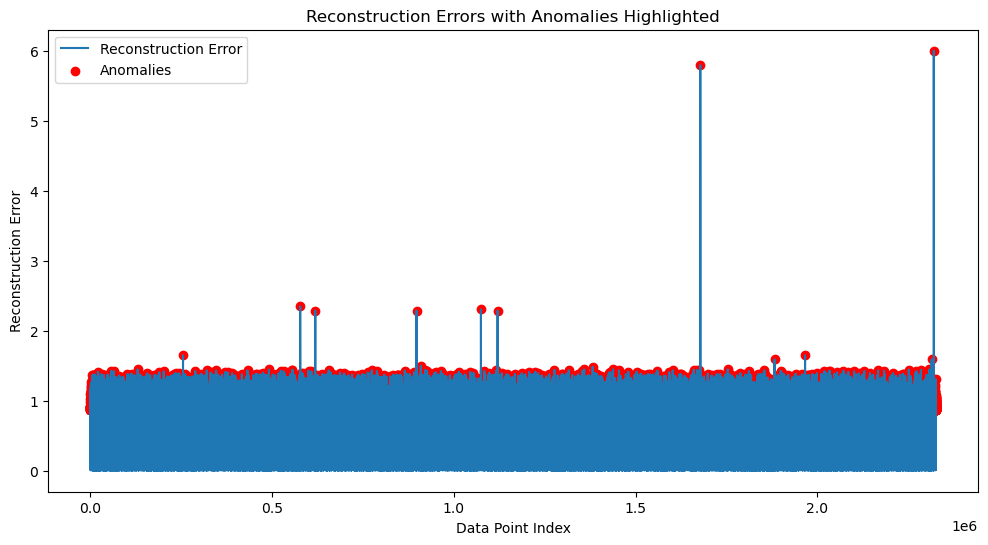

In [22]:
# Assuming anomalies is a boolean array where True indicates an anomaly
num_anomalies = np.sum(anomalies)
total_data_points = len(reconstruction_loss_normal)
percentage_anomalies = (num_anomalies / total_data_points) * 100

print(f"Number of potential anomalies: {num_anomalies}")
print(f"Percentage of total data points: {percentage_anomalies:.2f}%")

# Visualize the anomalies over time (if time-series data is available)
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_loss_normal, label='Reconstruction Error')
plt.scatter(np.where(anomalies)[0], reconstruction_loss_normal[anomalies], color='r', label='Anomalies')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors with Anomalies Highlighted')
plt.legend()
plt.show()

In [24]:
model.save('autoencoder_model(keras).keras')